# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [14]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
from numpy.linalg import det
import warnings
warnings.filterwarnings("ignore")

def gaussianKernel(sigma):
    n2 = np.int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

def trace(M):
    return M[0][0]+M[1][1]

def sobel_conv(I):
    
    Sx = np.array([[1,0,-1] ,[2,0,-2],[1,0,-1]])
    Sy = Sx.T
    return convolve2d(I,Sx,mode='same'), convolve2d(I,Sy,mode='same')


def computeHistogram(I):    
    res = np.unique(I, return_counts=True)
    
    return res

In [15]:
house2 = np.array(Image.open("img/house2.png"))
toyHorse1 = np.array(Image.open("img/toyHorse1.png"))
toyHorse2 = np.array(Image.open("img/toyHorse2.png"))

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [16]:
def computeR(image,scale,kappa):
    
    scale = (1/3) * int(0.5*(scale-1))
    
    Ix,Iy = sobel_conv(image)
    Ix_2 = Ix**2
    Iy_2 = Iy**2
    IxIy = Ix*Iy

    gauss_f = gaussianKernel(scale)
    Ix_2 = convolve2d(Ix_2,gauss_f,mode='same')
    Iy_2 = convolve2d(Iy_2,gauss_f,mode='same')
    IxIy = convolve2d(IxIy,gauss_f,mode='same')
    
    M = np.array([
        [Ix_2 , IxIy],
        [IxIy,Iy_2]
    ])

    deter = (Ix_2 * Iy_2)-(IxIy)**2
    return  deter - kappa * trace(M)**2

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

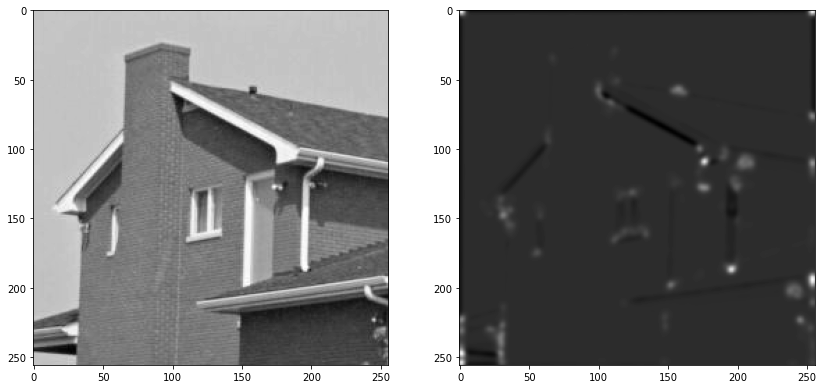

In [17]:
plt.figure(figsize=(14,7))


plt.subplot(121)
plt.imshow(house2,cmap='gray')

window = 15
plt.subplot(122)
plt.imshow(computeR(house2,window,0.04),cmap='gray')

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

lorsque les valeures de la matrice M sont faibles, l'image a une intensité constante,lorsque elles sont fortes , l'intensité varie fortement dans les deux directions ce qui caracterise un Coin . Lorsque une valeur propre est plus "tres" grande que l'autre alors la variation d'intensité s'opere sur une seule direction ce qui caracterise un contour .

Ainsi la reponse d'Harris R est positive au voisinage pour un coin , negative pour un contour et faible dans une region d'intensité constante ( ni contour ni coin )

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [35]:
def thresholdR(R, thres):
    return np.where(R < thres, 0, 1) 

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [37]:
def rnms(R, Rbin):
    
    n,m = R.shape
    resultat = np.zeros_like(R)
    for i in range(1,n-1):
        for j in range(1,m-1):
            nei = R[i-1:i+2,j-1:j+2]
            nei_max = np.max(nei)
            if R[i,j] == nei_max and Rbin[i,j] == 1:
                resultat[i,j] = 1
            
    return resultat    

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [40]:
def cornerDetector(image, scale, kappa, thres):
    R = computeR(image,scale,kappa)
    R_resultat = thresholdR(R,R.max() * thres)
    return rnms(R,R_resultat)    

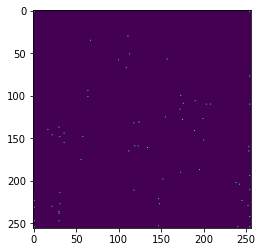

In [41]:
plt.imshow(cornerDetector(house2,15,0.04, 0.01))

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

In [42]:
def display_corners(Image,scale,kappa,thres):   
    plt.figure(figsize=(7,7))
    X, Y = np.nonzero(cornerDetector(Image,scale,kappa,thres).T)
    print(cornerDetector(Image,scale,kappa,thres).shape)
    plt.imshow(Image, cmap='gray')
    plt.scatter(X, Y,s=50, facecolors='none', edgecolors='b')

(256, 256)


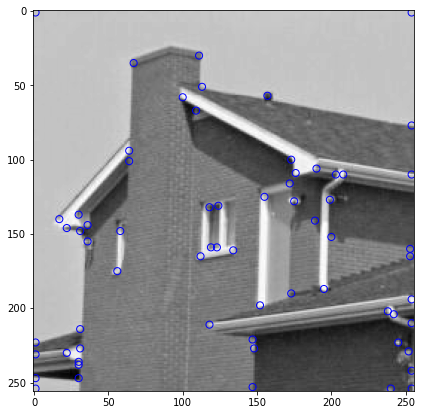

In [43]:
display_corners(house2,15,0.04,0.01)

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

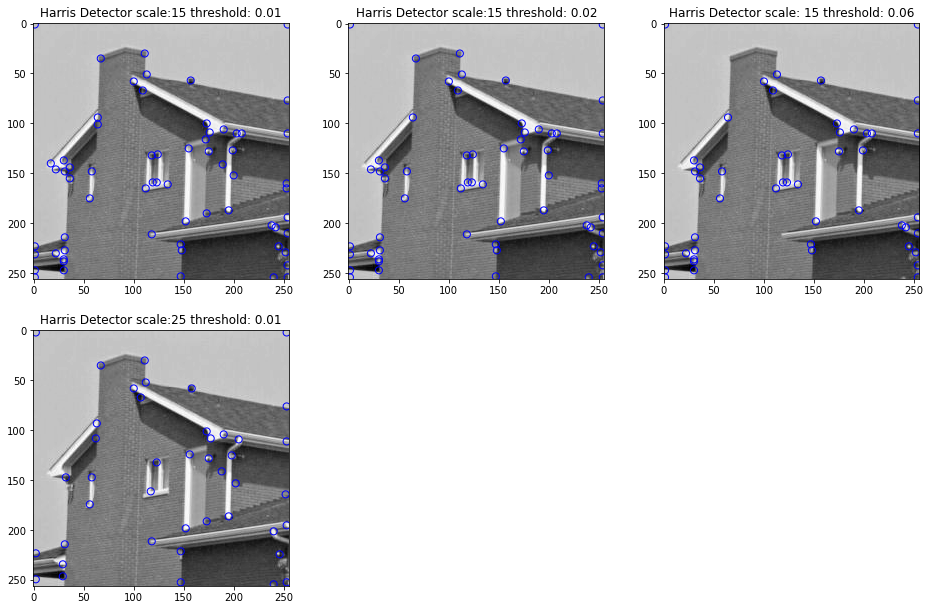

In [44]:
scales = [15,25,45]
thres = [0.01,0.02,0.06]

# Thres * R.Max()
plt.figure(figsize=(16,16))

X, Y = np.nonzero(cornerDetector(house2,scales[0],0.04,thres[0]).T)
plt.subplot(331)
plt.scatter(X, Y, s=50, facecolors='none', edgecolors='b')
plt.title(f"Harris Detector scale:{scales[0]} threshold: {thres[0]}")
plt.imshow(house2, cmap='gray')

X, Y = np.nonzero(cornerDetector(house2,scales[0],0.04,thres[1]).T)
plt.subplot(332)
plt.scatter(X, Y, s=50, facecolors='none', edgecolors='b')
plt.title(f"Harris Detector scale:{scales[0]} threshold: {thres[1]}")
plt.imshow(house2, cmap='gray')

X, Y = np.nonzero(cornerDetector(house2,scales[0],0.04,thres[2]).T)
plt.subplot(333)
plt.scatter(X, Y, s=50, facecolors='none', edgecolors='b')
plt.title(f"Harris Detector scale: {scales[0]} threshold: {thres[2]}")
plt.imshow(house2, cmap='gray')


X, Y = np.nonzero(cornerDetector(house2,scales[1],0.04,thres[0]).T)
plt.subplot(334)
plt.scatter(X, Y, s=50, facecolors='none', edgecolors='b')
plt.title(f"Harris Detector scale:{scales[1]} threshold: {thres[0]}")
plt.imshow(house2, cmap='gray')

Le threshold influe sur la suppression du bruit d'une maniere pas tres descriminatoire tandis que le scale dans ce cas de figure lisse le R au point d'eliminer meme des coins assez flagrants 

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

(672, 529)


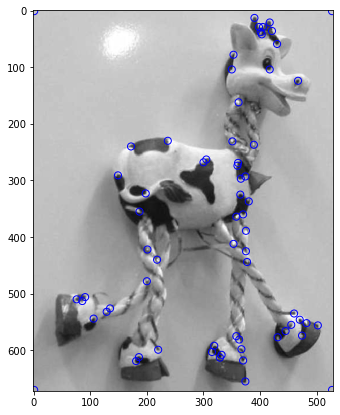

In [45]:
display_corners(toyHorse1,15,0.04,0.06)

(671, 507)


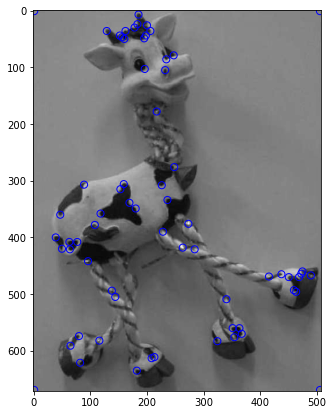

In [46]:
display_corners(toyHorse2,15,0.04,0.06)

Le detecteur d'Harris avec un threshold dynamique a pu detecter pratiquement les memes coins sur l'image originale et sur l'image auquel on a fait des transformations ( rotation , changement de luminosité ) 

2) What are the dynamic ranges of these two images ?

- Les deux images sont encodées sur 8bits --> 256 valeurs.
- de 1 à 255 pour l'image 1.
- de 0 a 253 pour l'image 2.

min : 1  max : 255


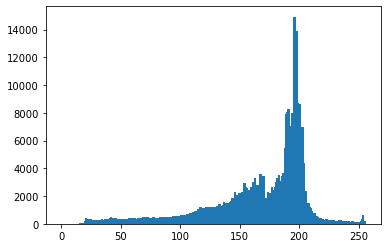

In [47]:
pixels, values =computeHistogram(toyHorse1)
print("min :",toyHorse1.min()," max :",toyHorse1.max())
plt.bar(pixels, values,2)
plt.show()

min : 0  max : 253


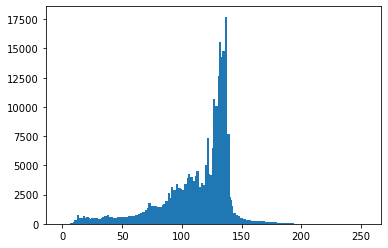

In [48]:
pixels, values =computeHistogram(toyHorse2)
print("min :",toyHorse2.min()," max :",toyHorse2.max())
plt.bar(pixels, values,2)
plt.show()

3) What are the transformations beetween the two images ?

- On remarque qu'on a plus de pixels proches de 255 pour l'image1 que l'image2 ce qui explique la différence de lumunosité entre les deux images
- Une rotation a ete effectué sur l'image2 .

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Le detecteur d'Harris ne fonctionne pas pour un seuil fixe et n'est pas sensible à la rotation.